In [125]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt 

In [23]:
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2})

In [2]:
%matplotlib inline

In [3]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [204]:
query = """
SELECT
	CASE
		WHEN course_partner IN (
			'ACCA',
			'AmnestyInternationalX',
            'CatalystX',
            'Catalystx',
			'ETSx',
			'FullbridgeX',
			'IDBx',
			'IEEEx',
			'IMF',
			'IMFx',
			'IRTIx',
			'LinuxFoundationX',
			'MandarinX',
			'NYIF',
			'RedHat',
			'SmithsonianX',
			'W3Cx',
			'WBGx'
		) THEN 'non_university'
		ELSE 'university'
	END AS university_non_university,
    	CASE
		WHEN a.course_subject IN
		(
			'Biology & Life Sciences',
			'Chemistry',
			'Computer Science',
			'Data Analysis & Statistics',
			'Electronics',
			'Energy & Earth Sciences',
			'Engineering',
			'Math',
			'Physics',
			'Science'
		) THEN 'STEM'
		ELSE 'non-STEM'
    END AS stem_non_stem,
	*
FROM
	business_intelligence.course_master a
JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
AND
	course_start_date >= '2016-07-01'
AND 
	course_end_date <= CURRENT_DATE()
AND 
	course_partner NOT IN ('HarvardX','MITx','Microsoft')
AND
	sum_enrolls > 1000
AND
    sum_bookings > 0 
AND
    vtr > 0
"""

In [205]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(query)
extract = cur.fetchall()
df = pd.DataFrame(extract)

connection.close()

In [206]:
df = df.fillna(0)
df['vtr'] = df['vtr'].astype('float64') * 100
df['sum_bookings'] = df['sum_bookings'].astype('float64')
df['expected_value'] = df['vtr'] * df['course_seat_price']

In [207]:
df.groupby('university_non_university').count()['course_id']

university_non_university
non_university     72
university        507
Name: course_id, dtype: int64

In [208]:
df.columns

Index(['university_non_university', 'stem_non_stem', 'course_id',
       'course_subject', 'is_WL', 'course_name', 'course_start_date',
       'course_end_date', 'course_announcement_date',
       'course_enrollment_start_date', 'course_enrollment_end_date',
       'course_seat_price', 'content_language', 'pacing_type', 'level_type',
       'course_verification_end_date', 'is_active',
       'has_verification_deadline_passed', 'days_to_course_start',
       'days_to_course_end', 'days_to_verification_deadline', 'course_number',
       'course_run_number', 'course_partner', 'course_about_url',
       'course_reporting_type', 'sum_enrolls', 'sum_unenrolls',
       'sum_verifications', 'sum_enrolls_vtr', 'vtr', 'bookings_per_enroll',
       'cnt_paid_enrollments', 'sum_bookings', 'sum_seat_bookings',
       'sum_donations_bookings', 'sum_reg_code_bookings', 'sum_completions',
       'sum_certificates', 'expected_value'],
      dtype='object')

In [215]:
def transform_variable(df, transform_list):
    
    for i in transform_list:
        col_name = i + '_transform'
        df[col_name] = scipy.stats.boxcox(df[i])[0]
        
    return df

In [218]:
def plot_distributions(df, metric):
    
    plt.figure()
    ax = sns.distplot(
        df[df['university_non_university']=='university'][metric],
        color = '#0075b4',
        label = 'university',
        kde = False,
        hist_kws=dict(alpha=0.6)
    )
    ax = sns.distplot(
        df[df['university_non_university']!='university'][metric],
        color = '#c2387d',
        label = 'non-university',
        kde = False,
        hist_kws=dict(alpha=0.6)
    )
    ax.set(title = 'University vs Non-University, %s' % metric)
    ax.legend()

In [219]:
transform_list = [
    
    'sum_enrolls',
    'vtr',
    'sum_bookings',
    'sum_verifications',
    'course_seat_price',
    'expected_value'

]

df = transform_variable(df, transform_list)

In [220]:
plot_list = [
    
    'sum_enrolls',
    'vtr',
    'sum_bookings',
    'sum_verifications',
    'course_seat_price',
    'expected_value',
    'sum_enrolls_transform',
    'vtr_transform',
    'sum_bookings_transform', 
    'sum_verifications_transform',
    'course_seat_price_transform',
    'expected_value_transform',
    
]

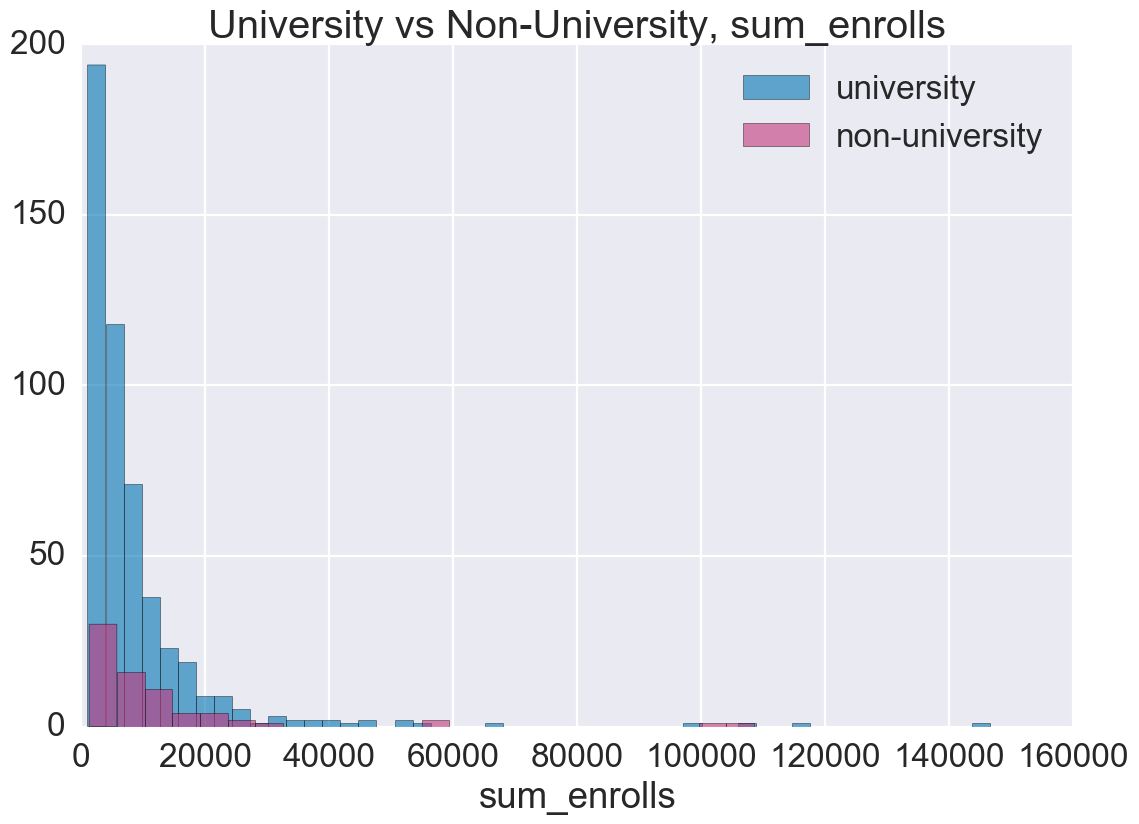

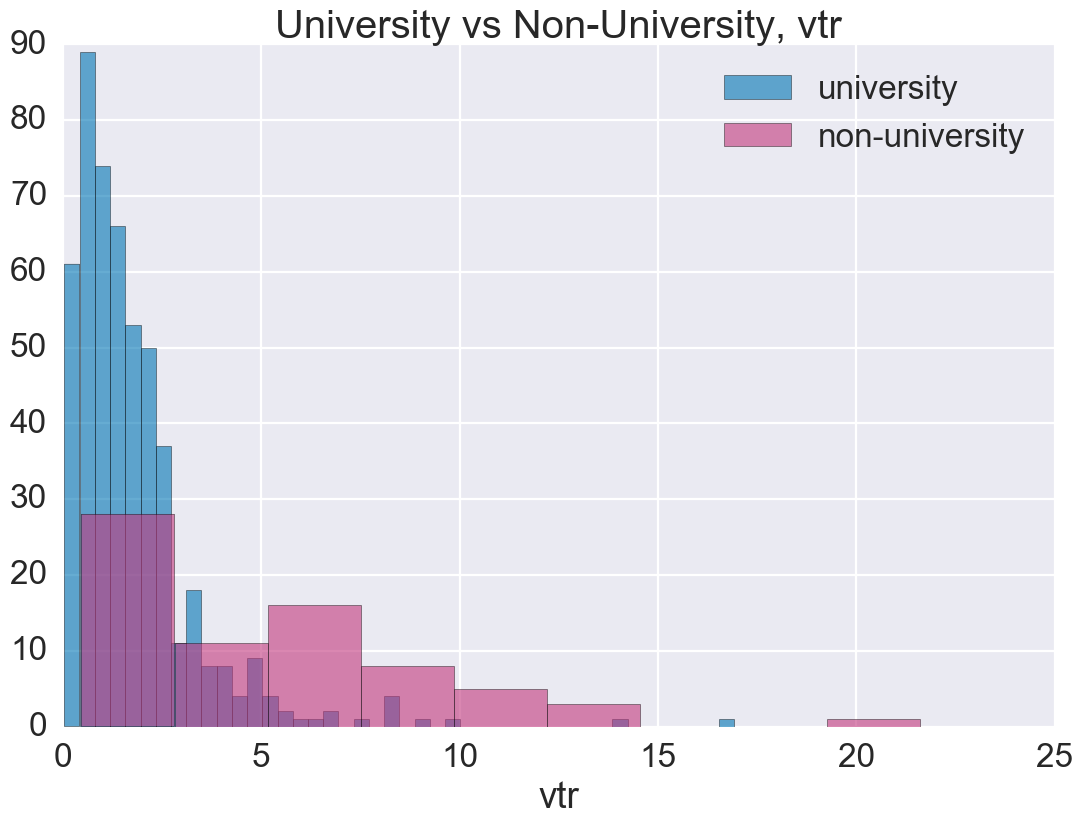

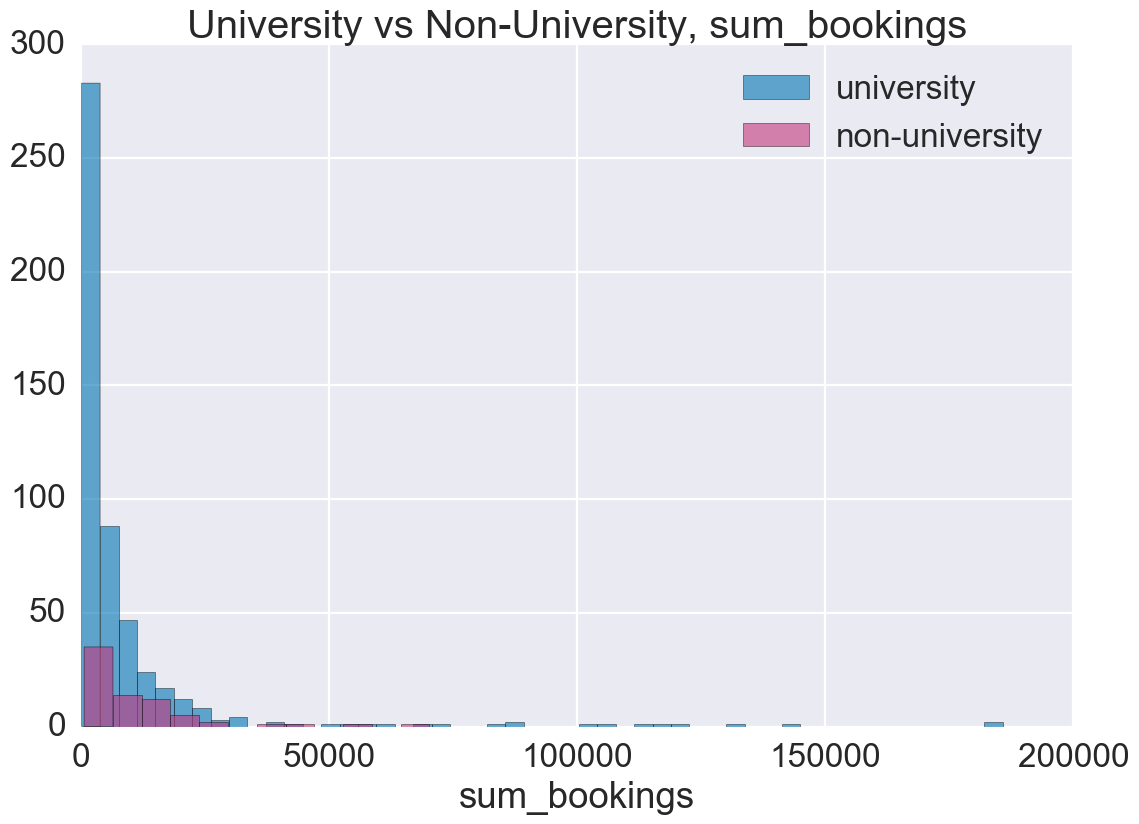

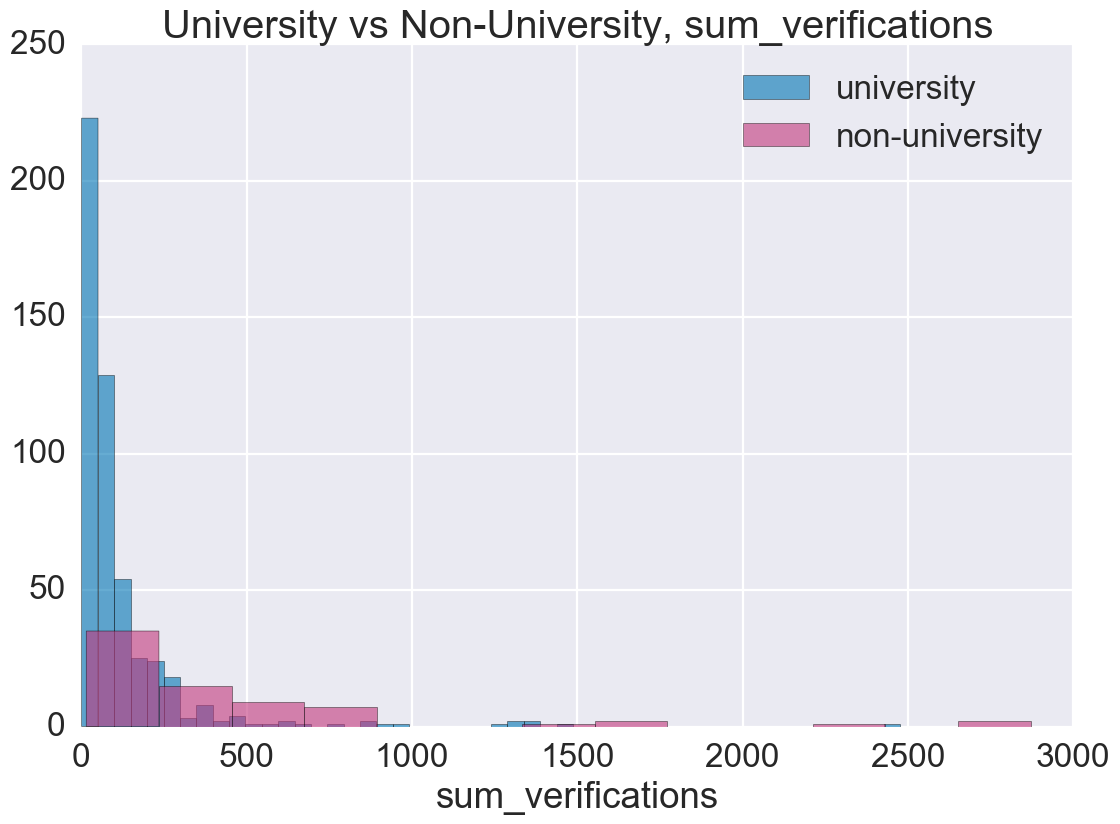

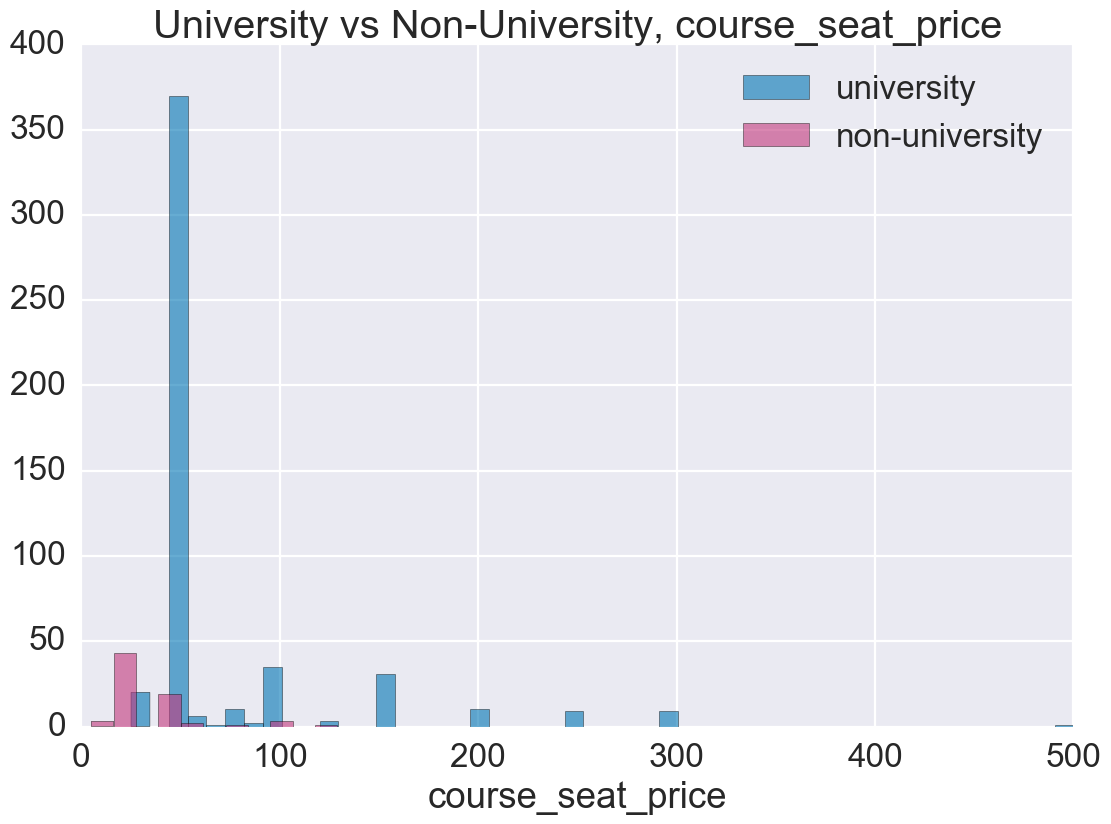

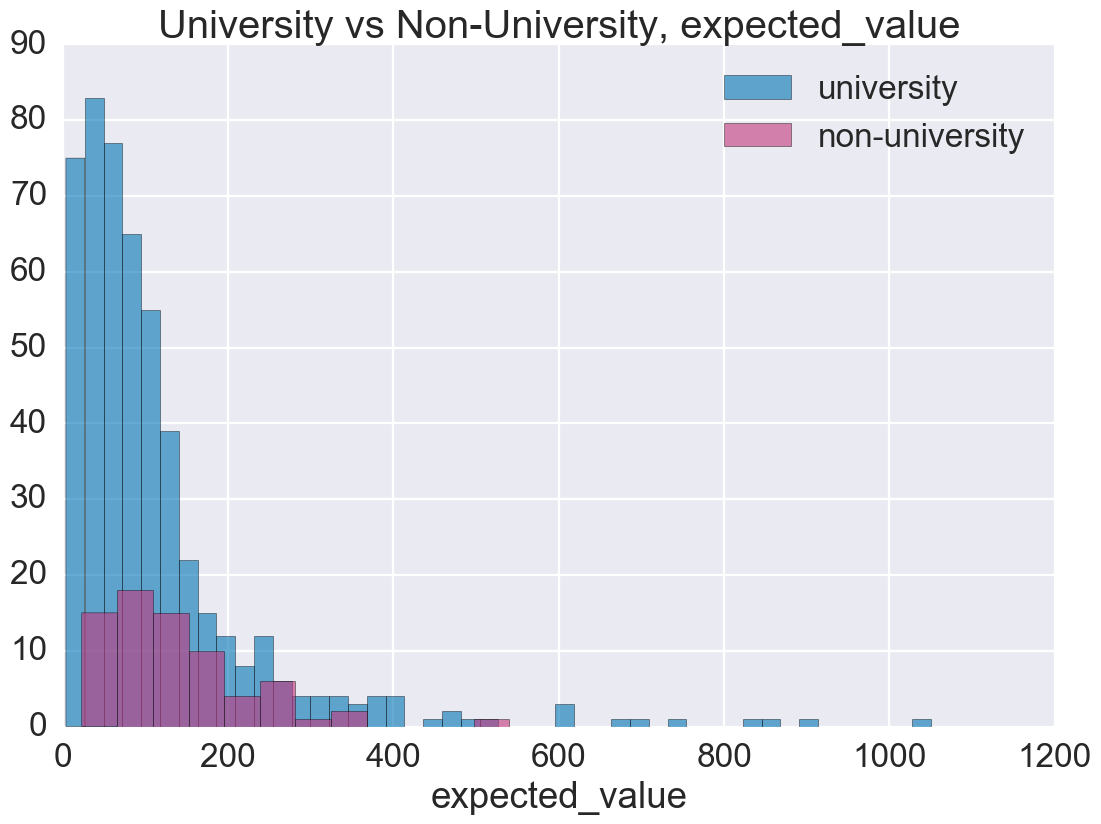

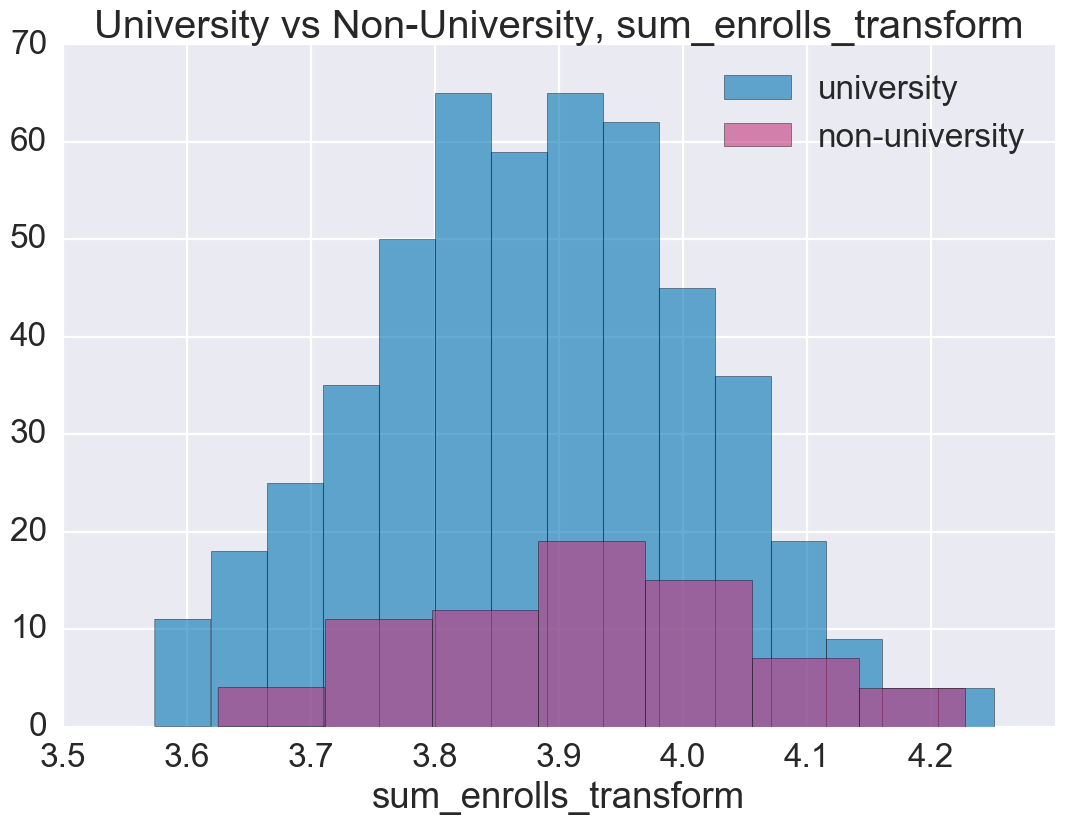

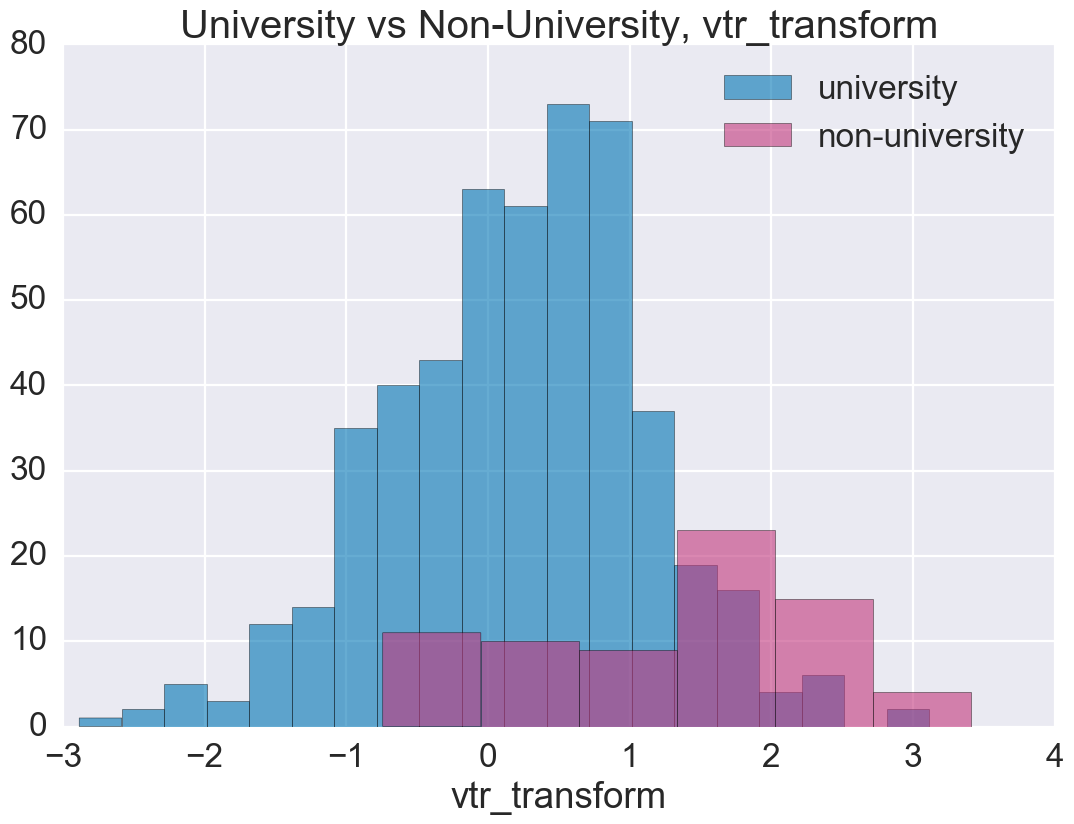

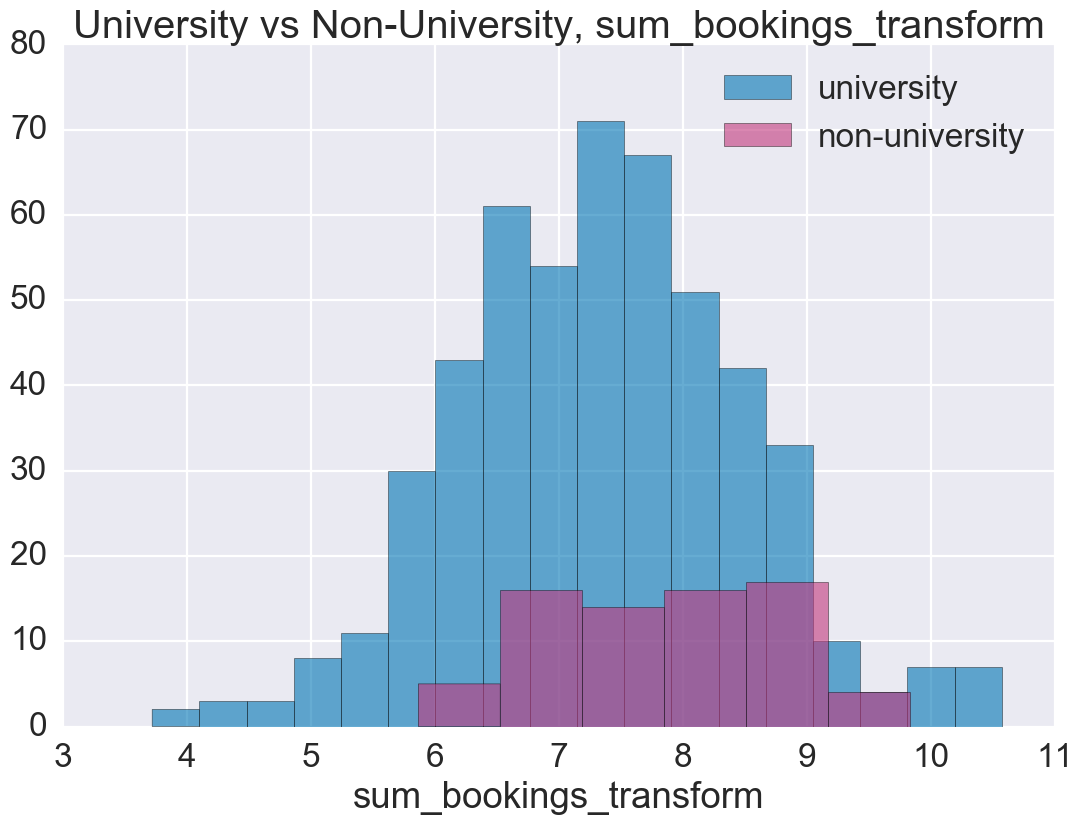

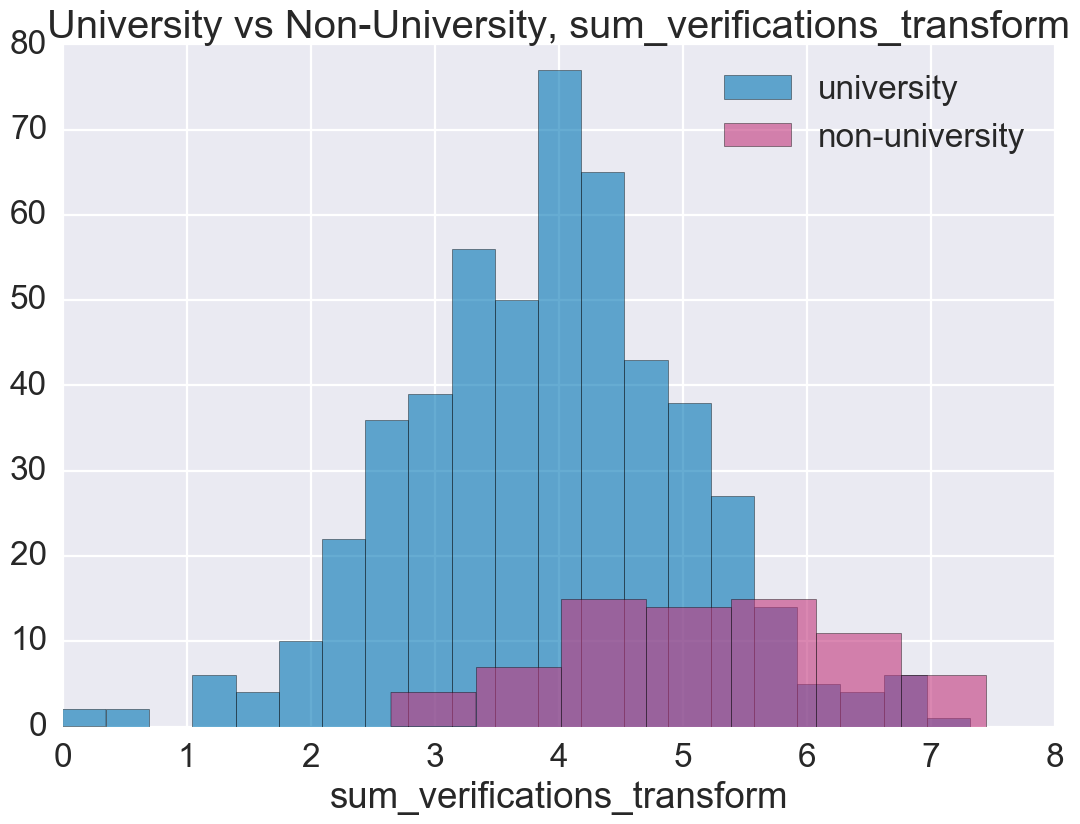

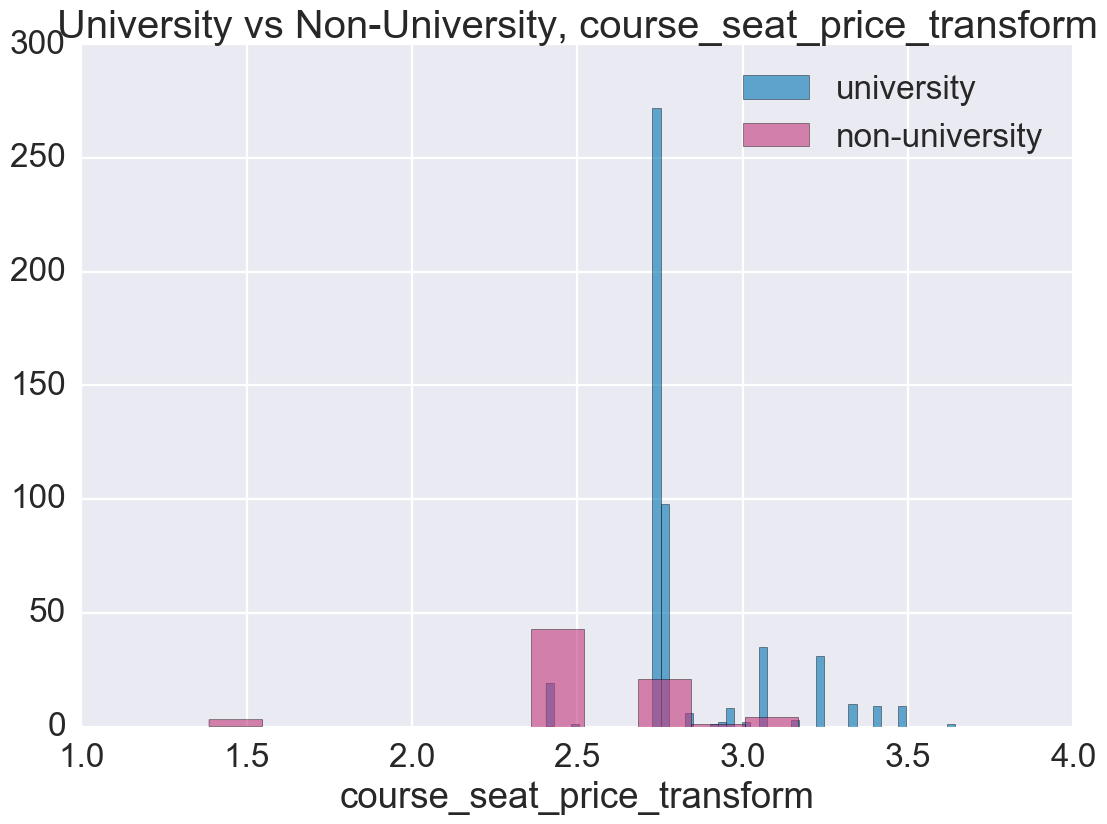

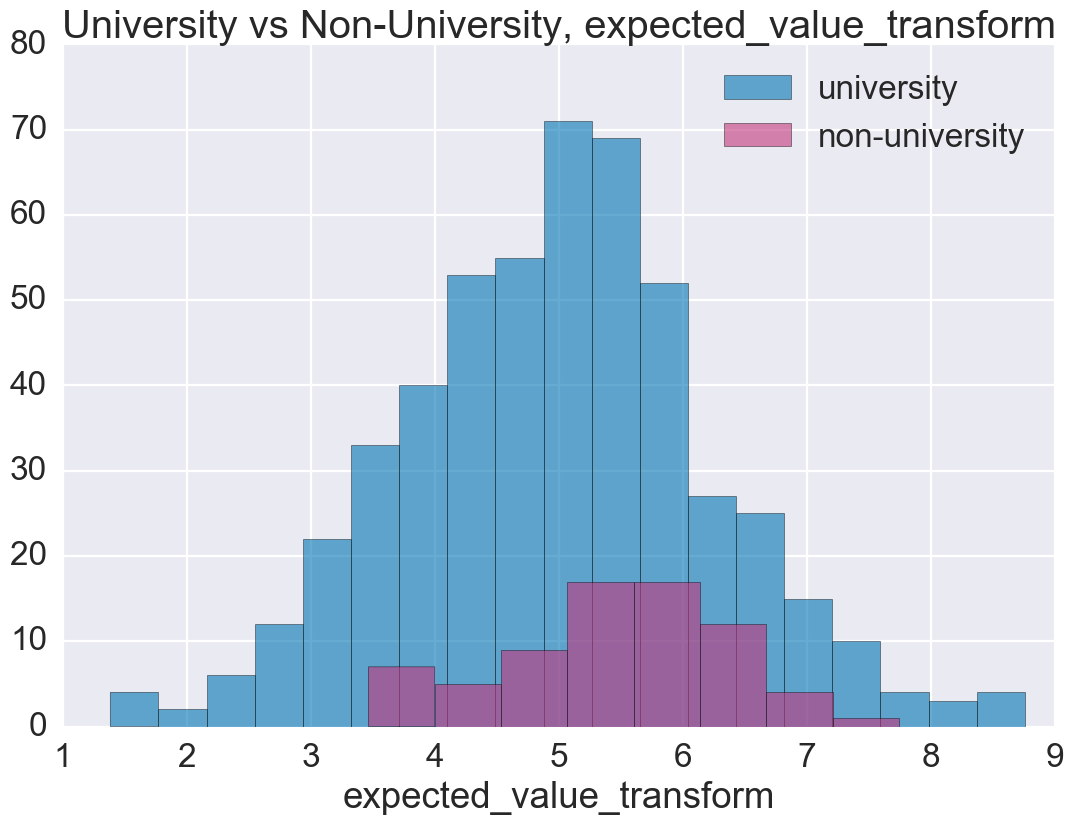

In [221]:
for i in plot_list:
    plot_distributions(df,i)

In [223]:
df.groupby(['stem_non_stem','university_non_university']).count()['course_id']

stem_non_stem  university_non_university
STEM           non_university                14
               university                   202
non-STEM       non_university                58
               university                   305
Name: course_id, dtype: int64

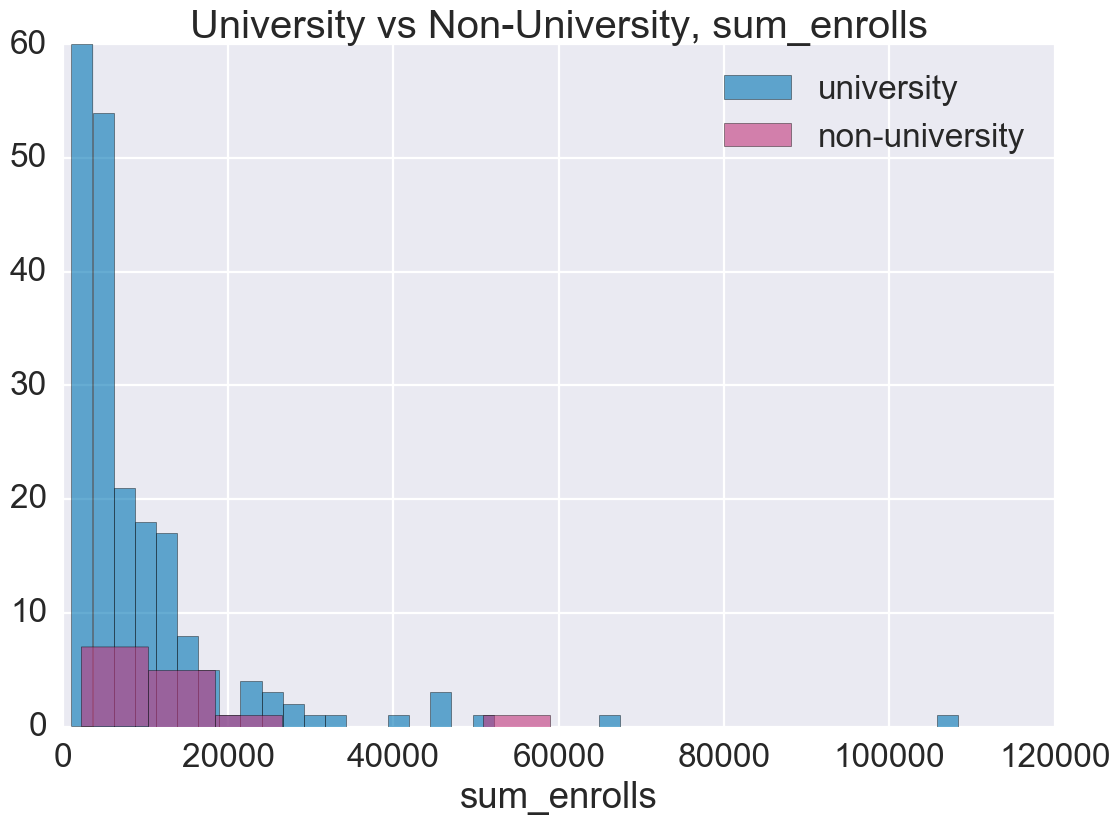

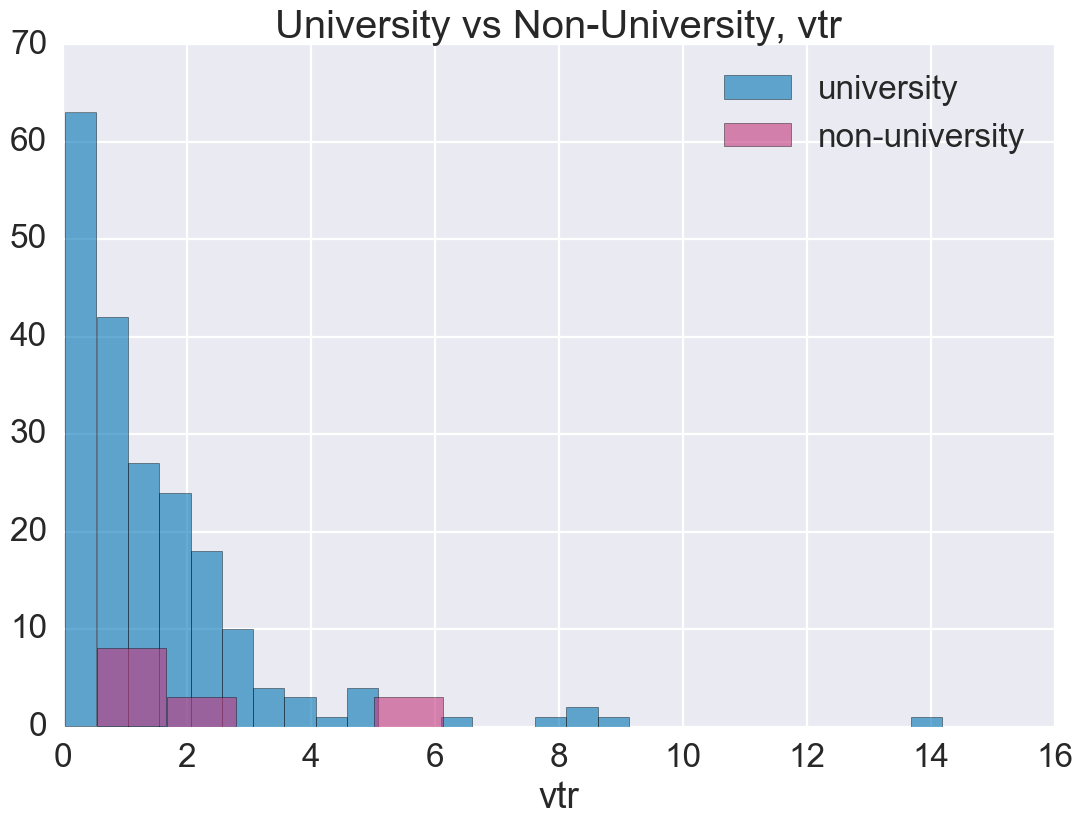

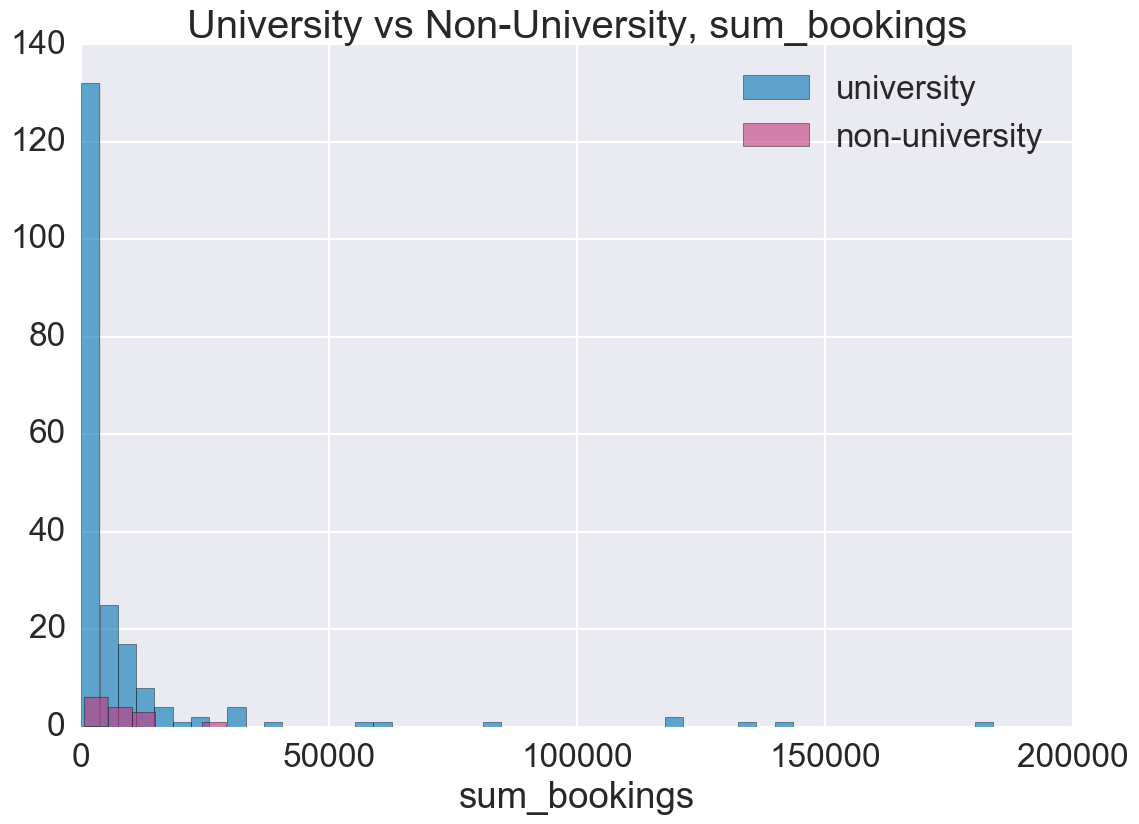

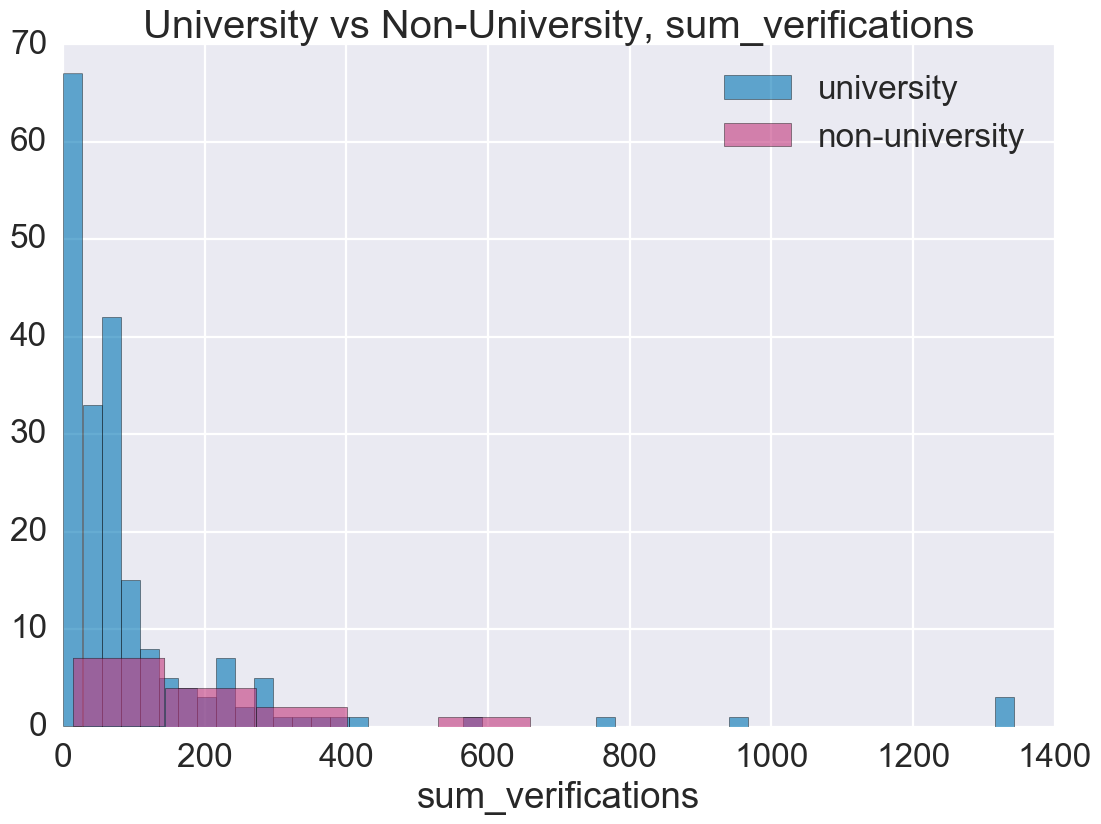

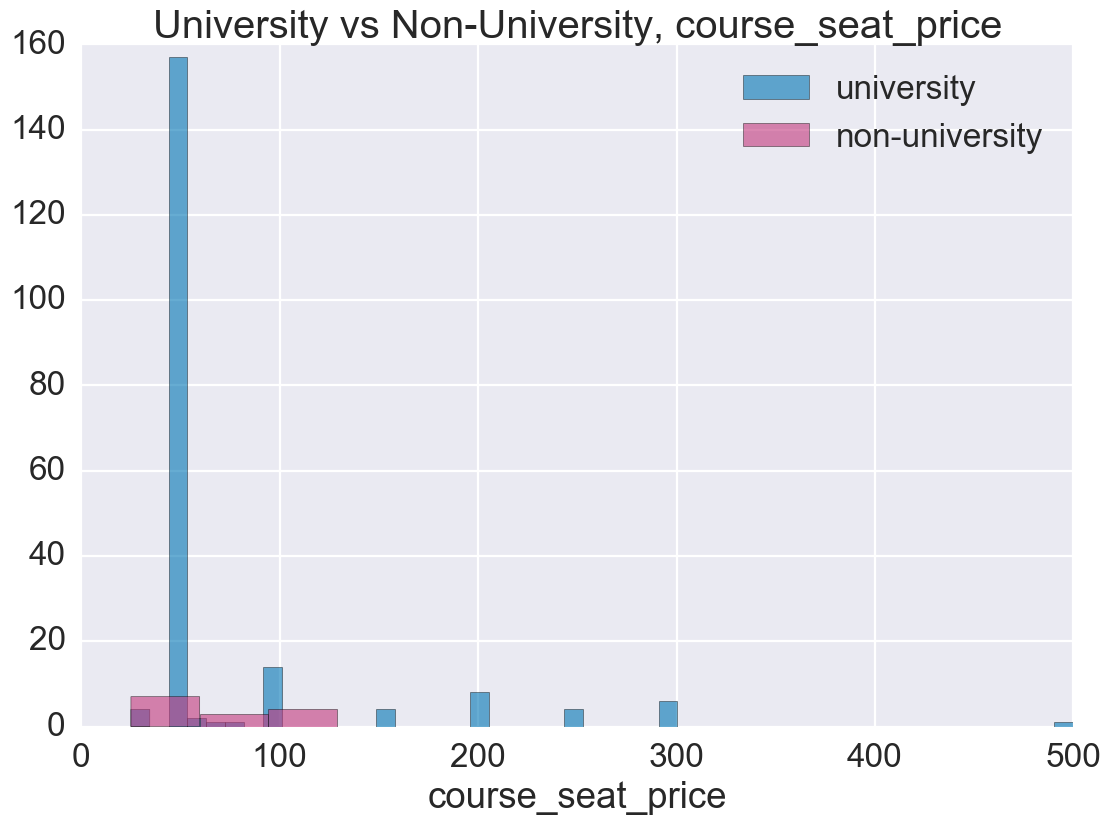

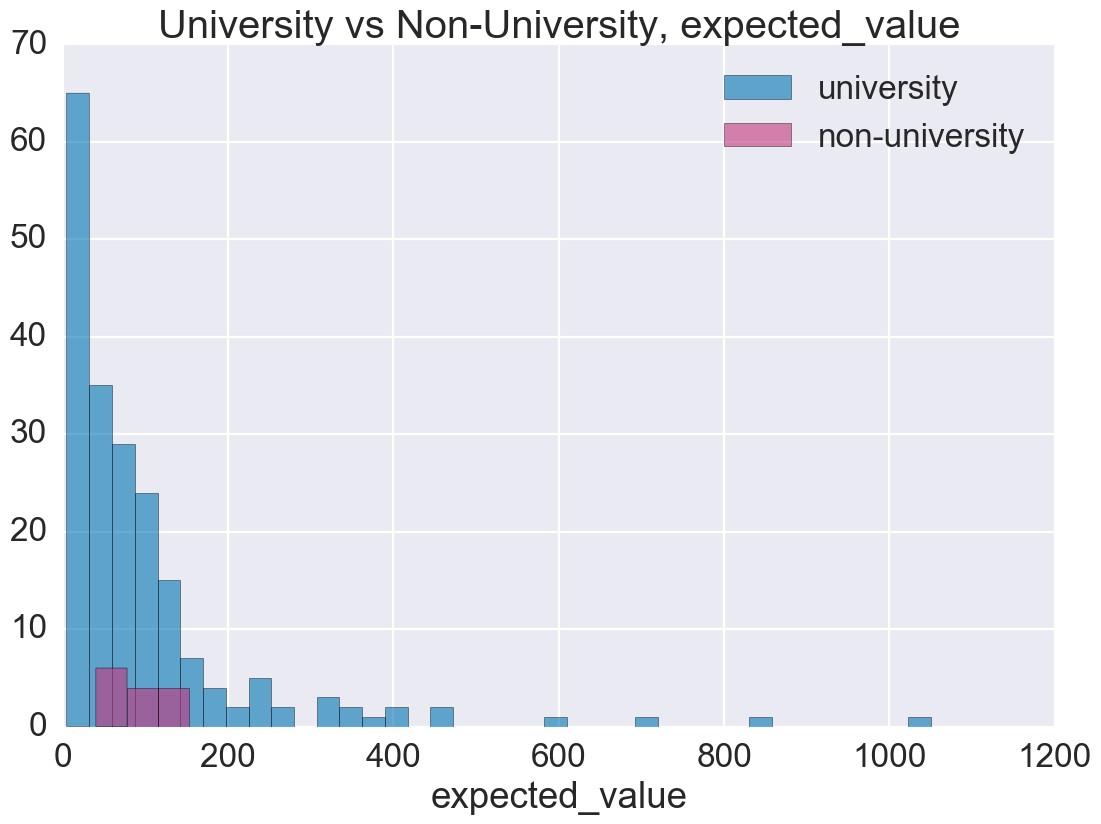

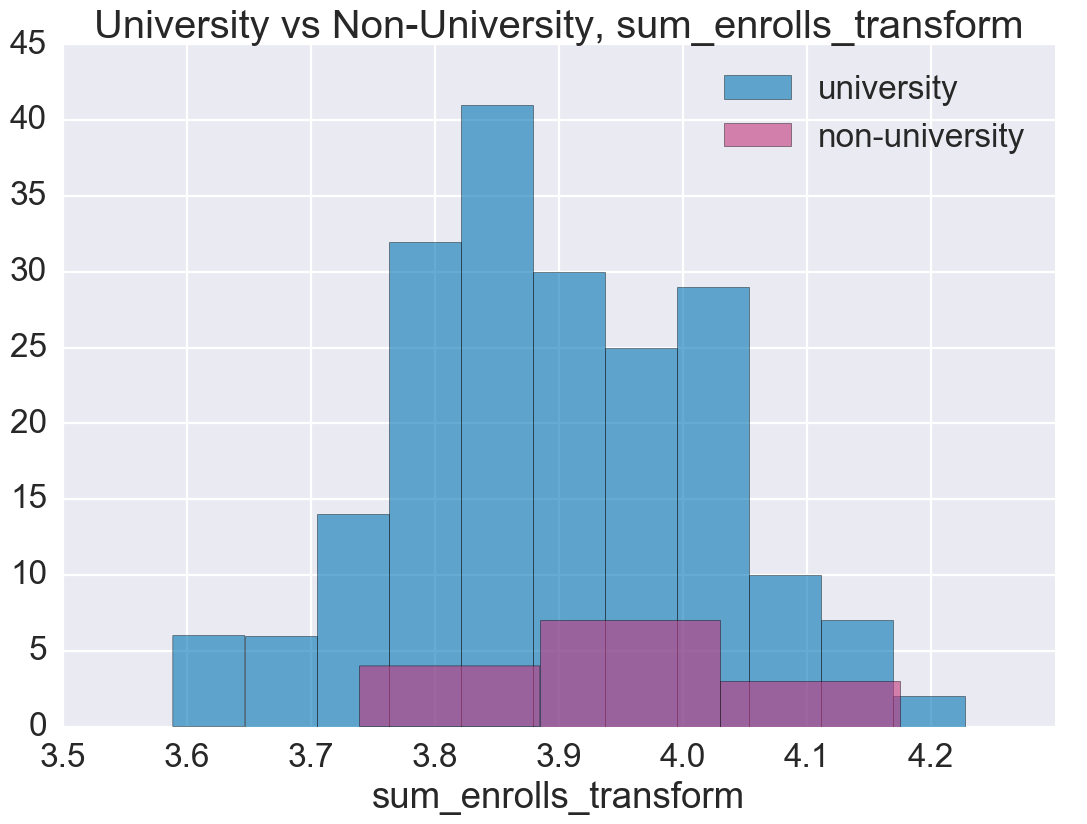

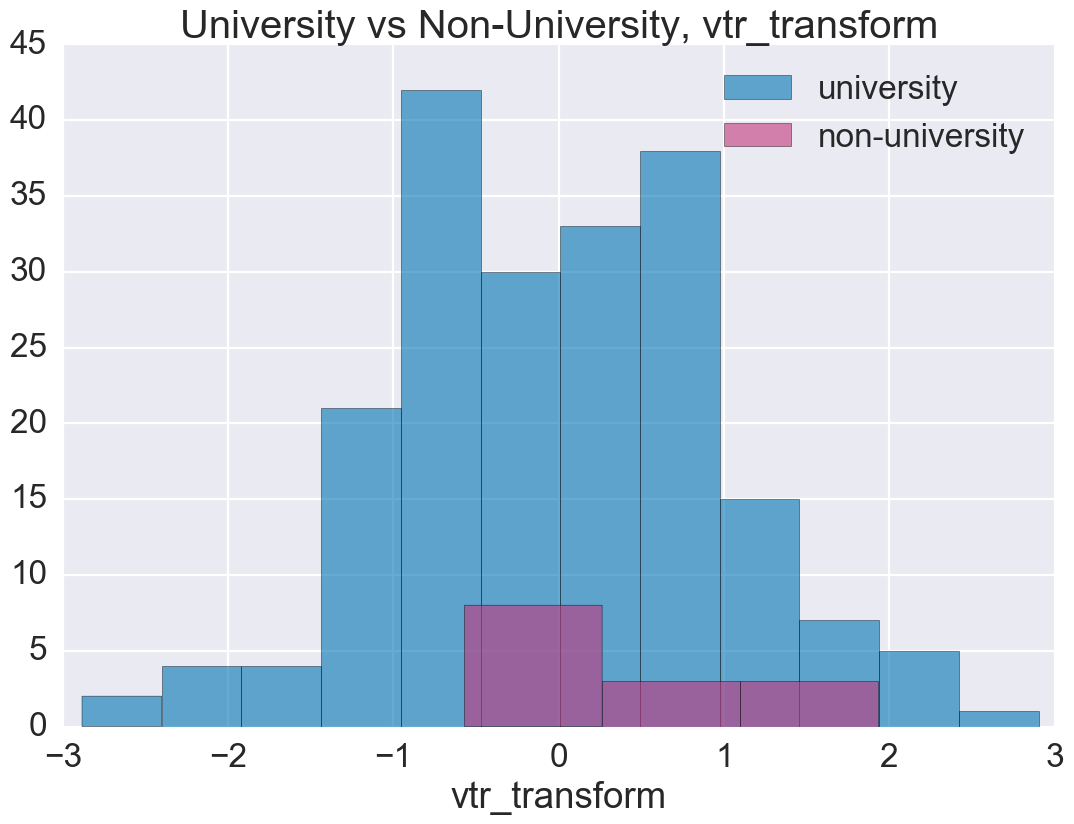

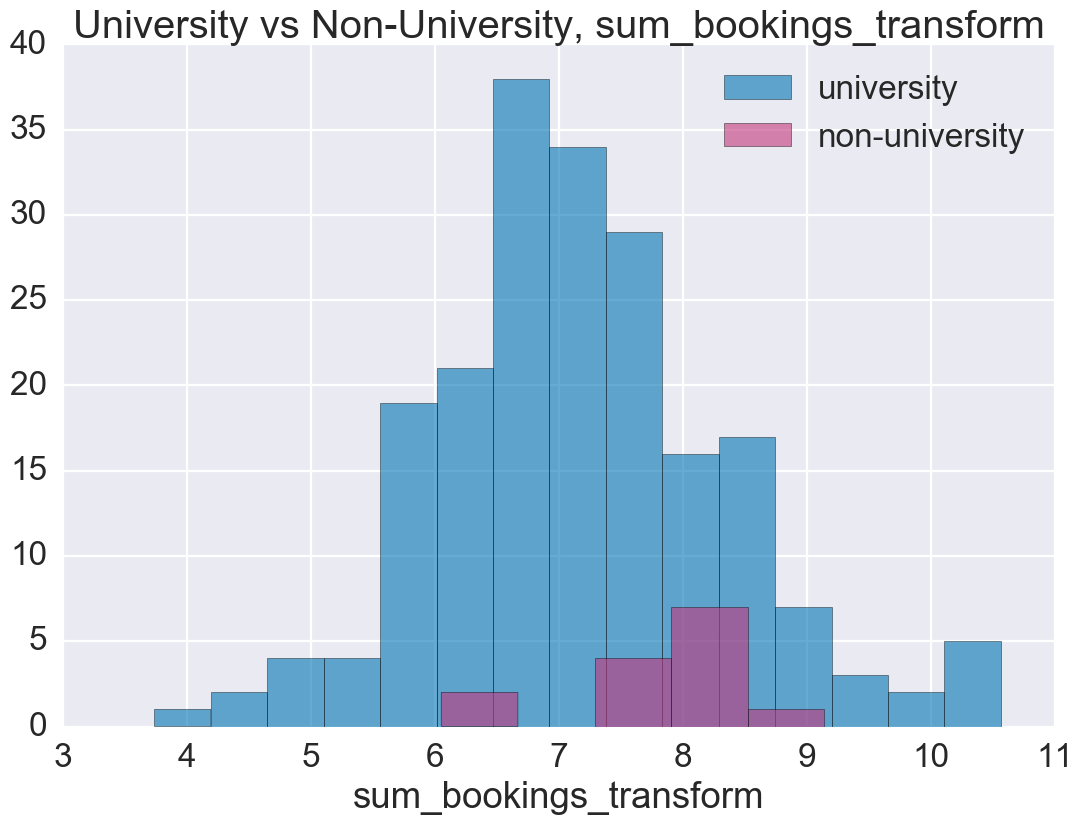

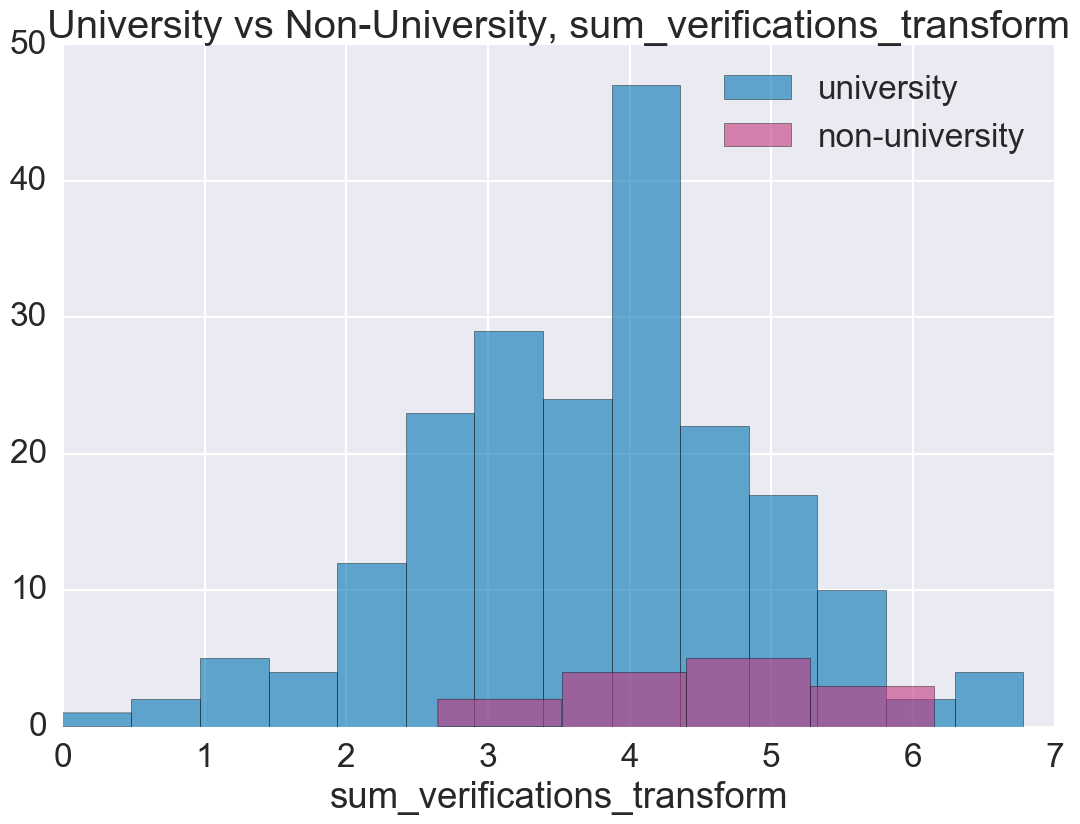

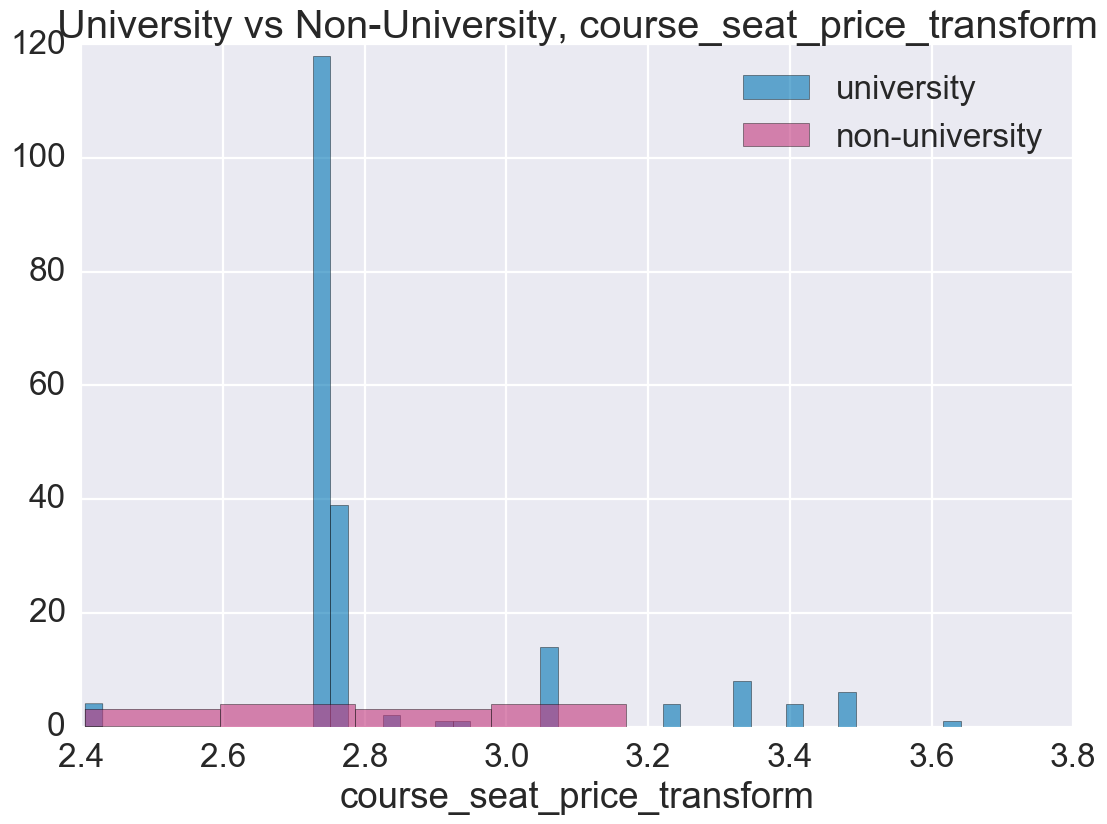

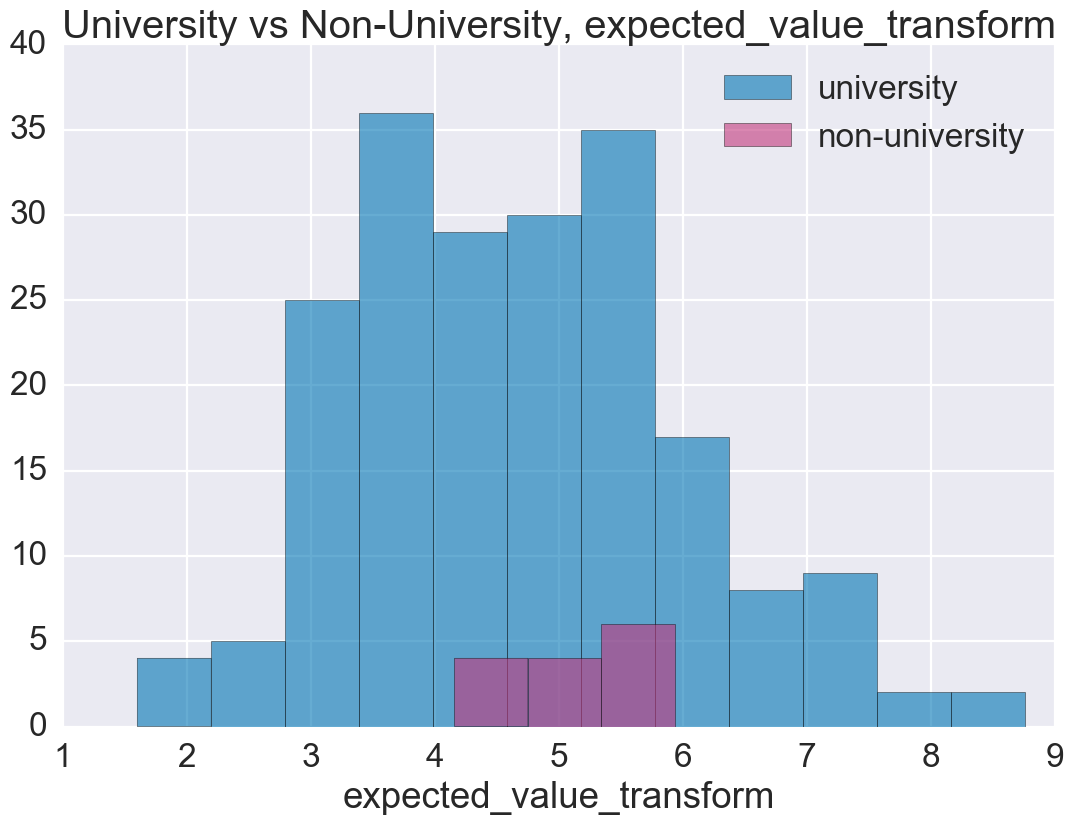

In [224]:
for i in plot_list:
    plot_distributions(df[df['stem_non_stem']=='STEM'],i)

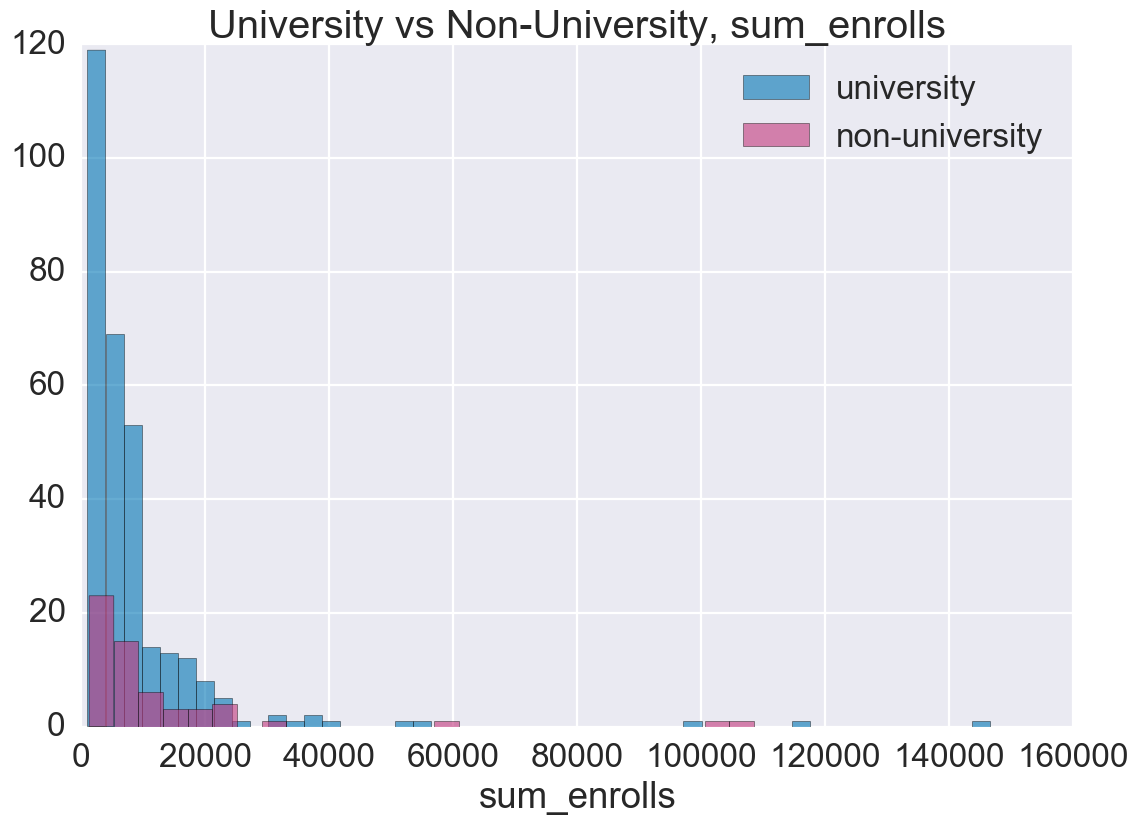

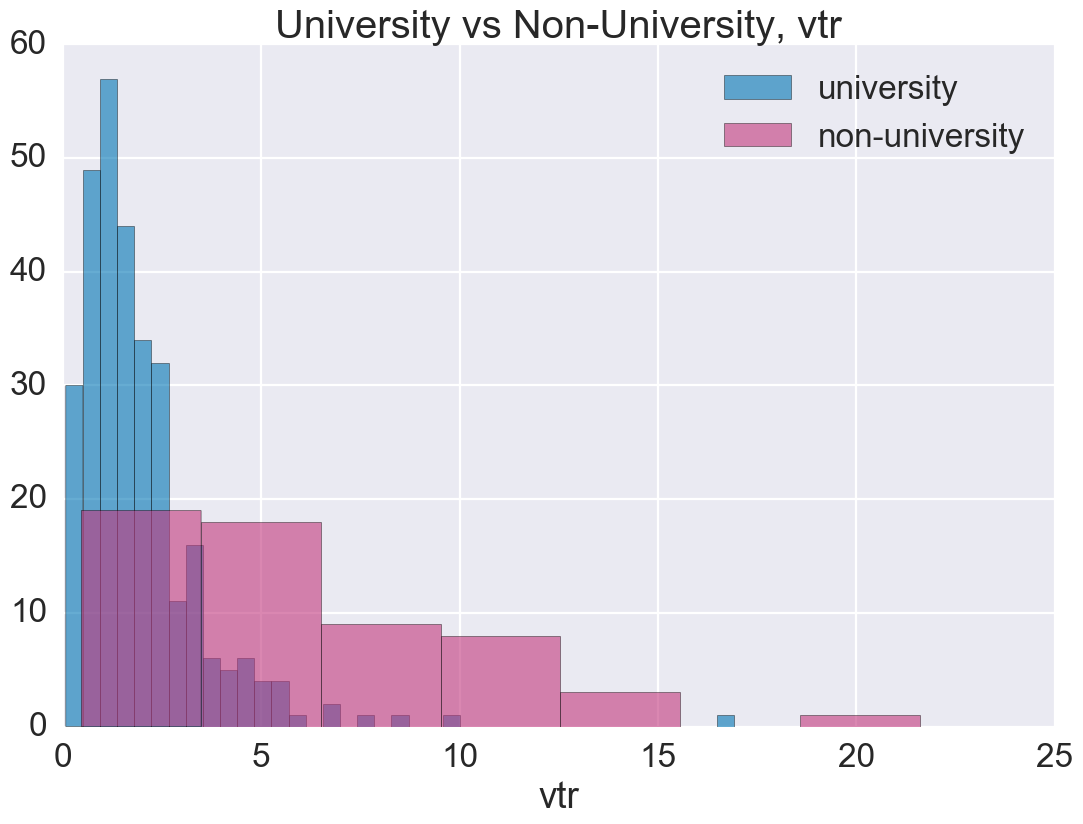

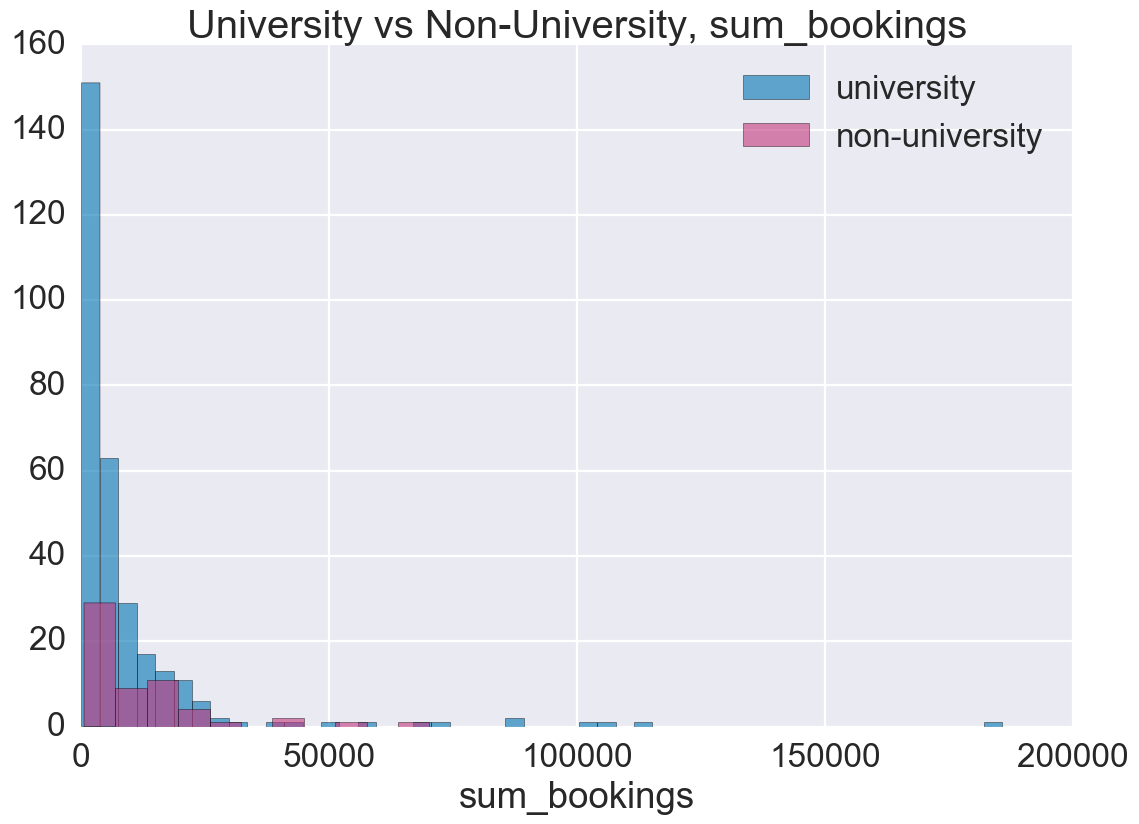

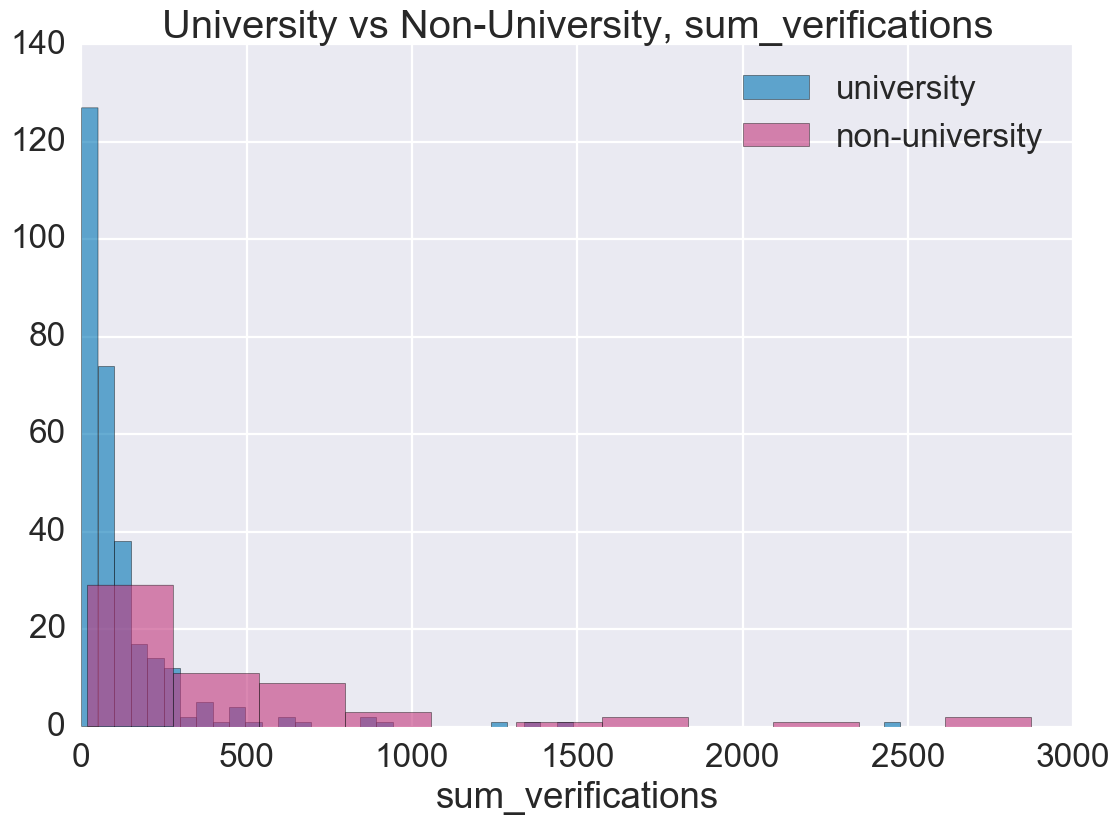

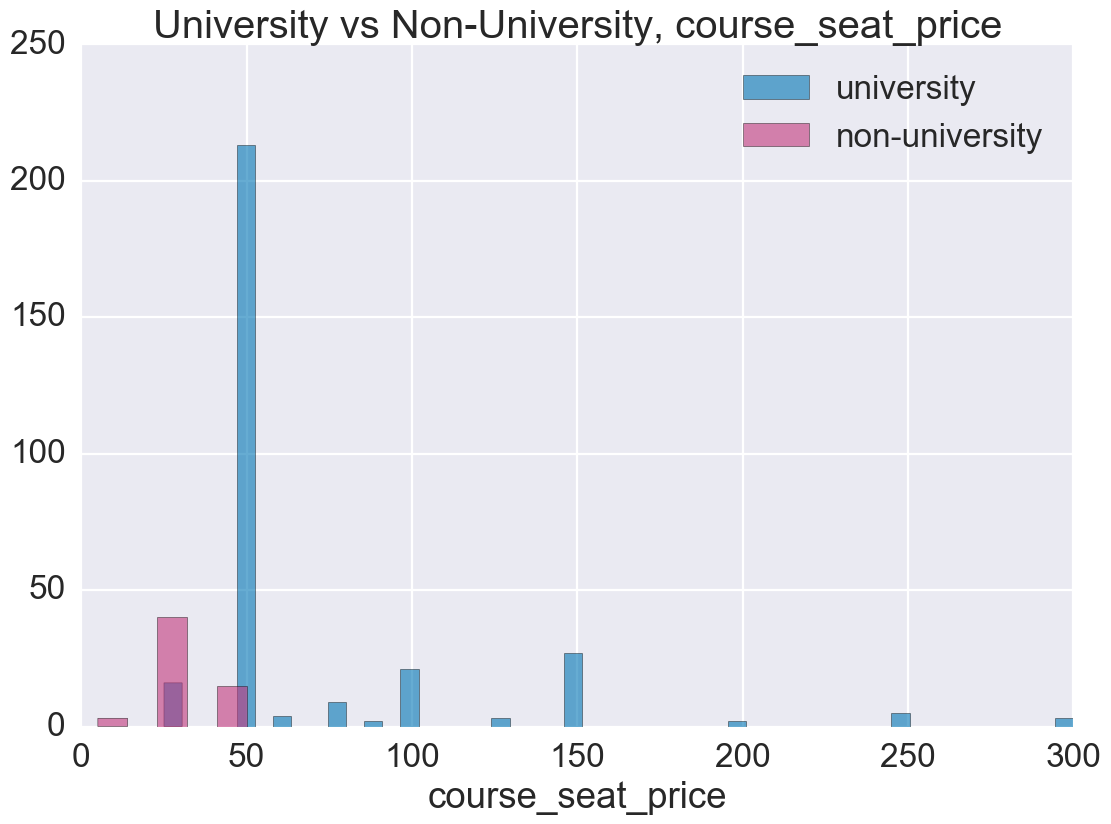

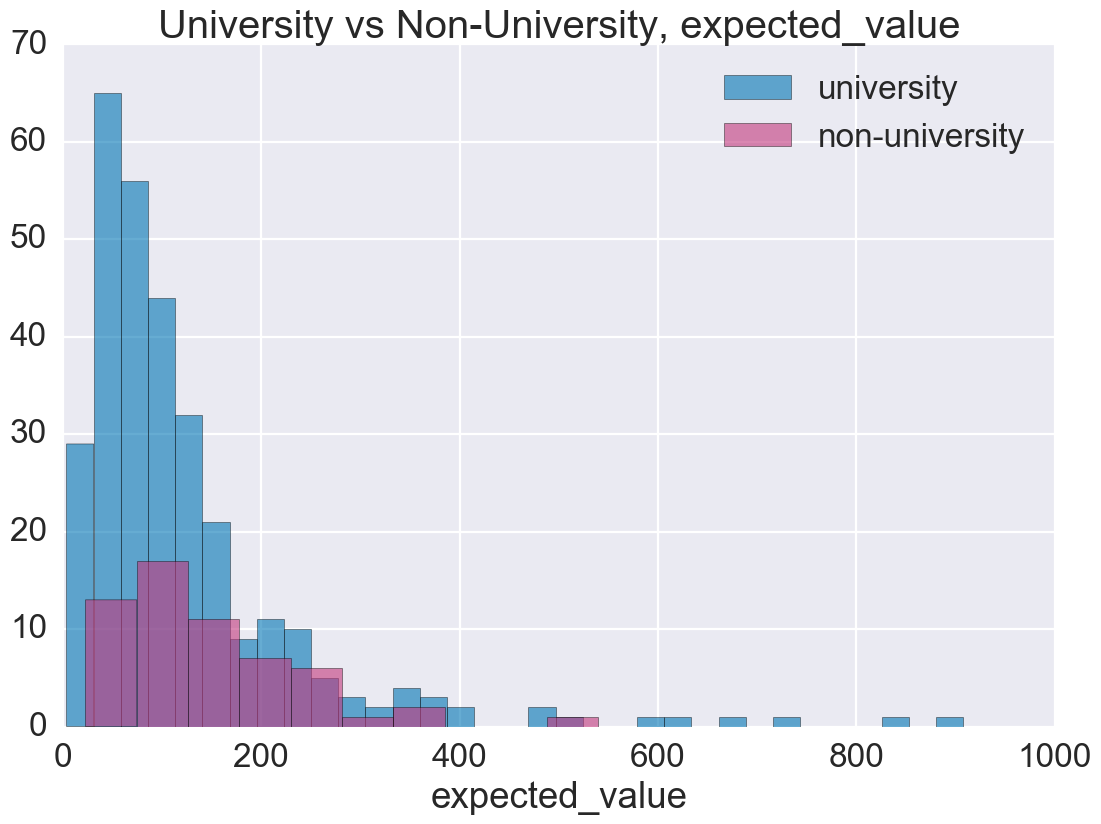

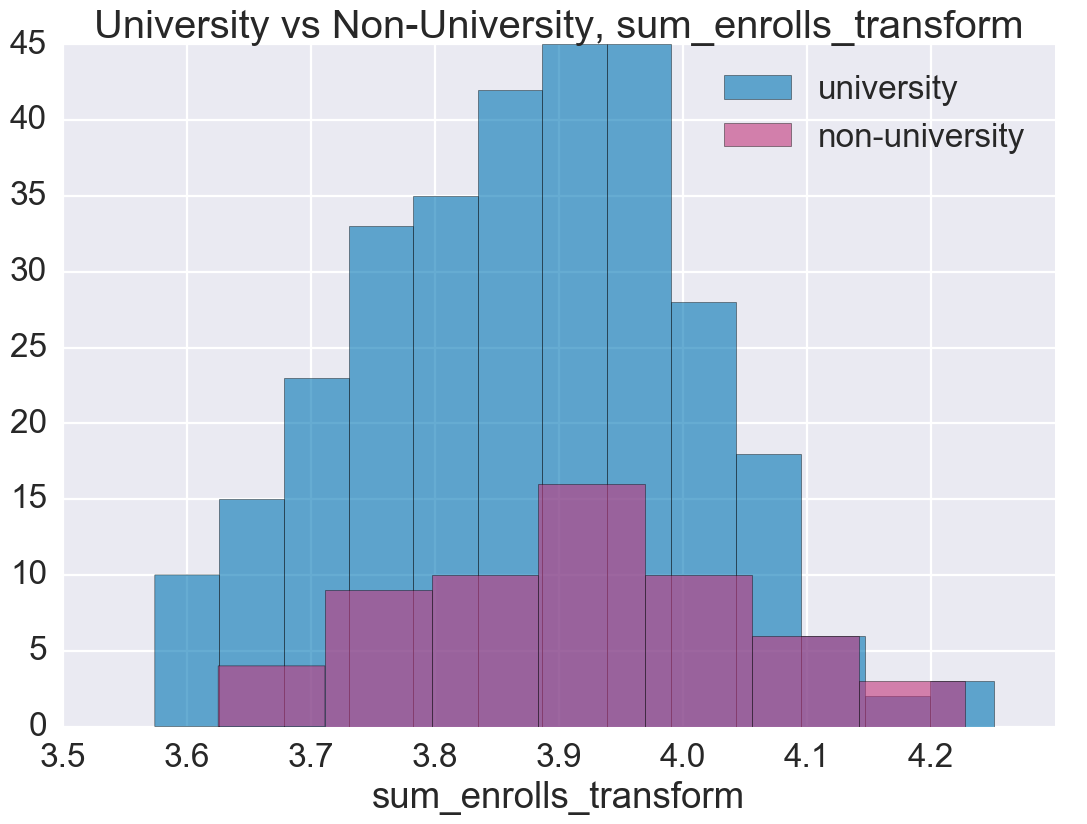

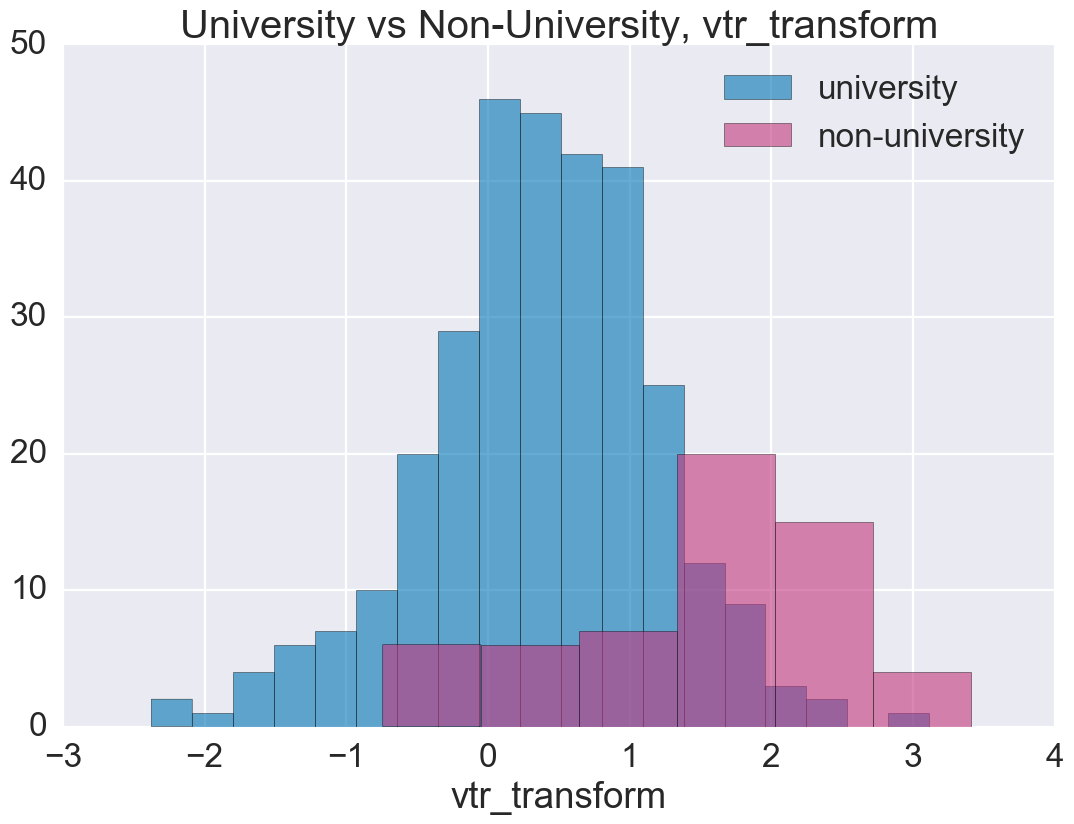

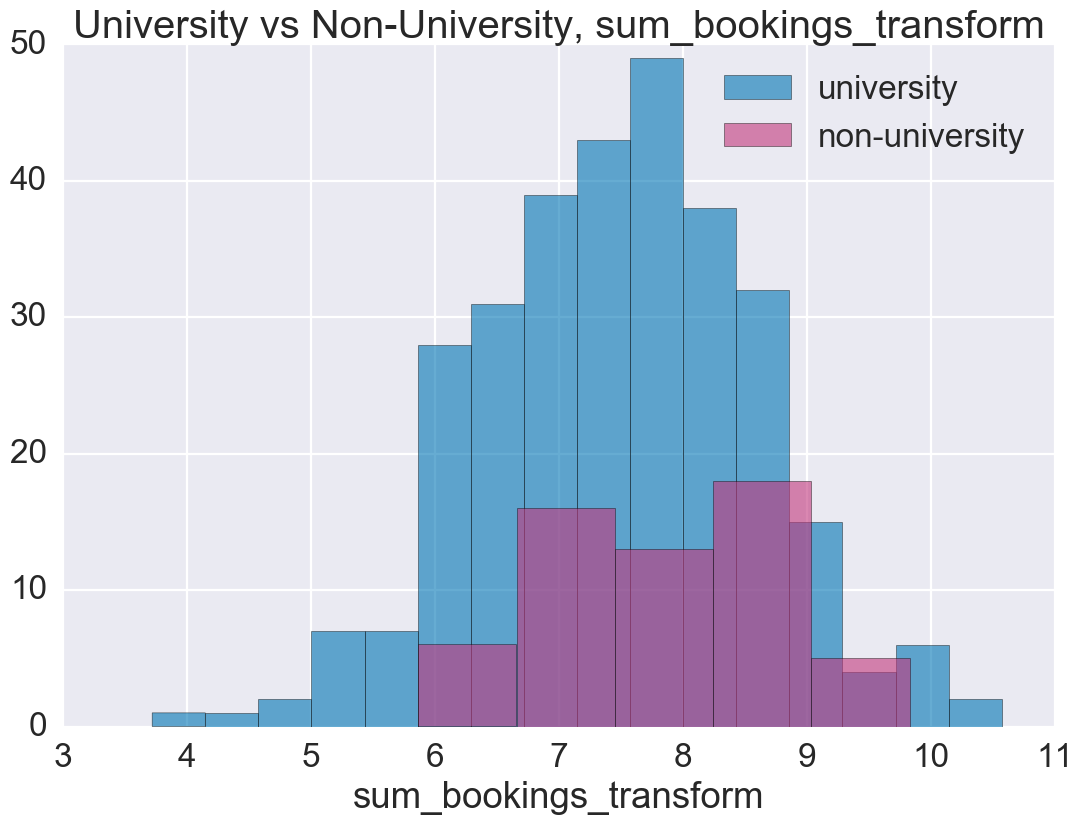

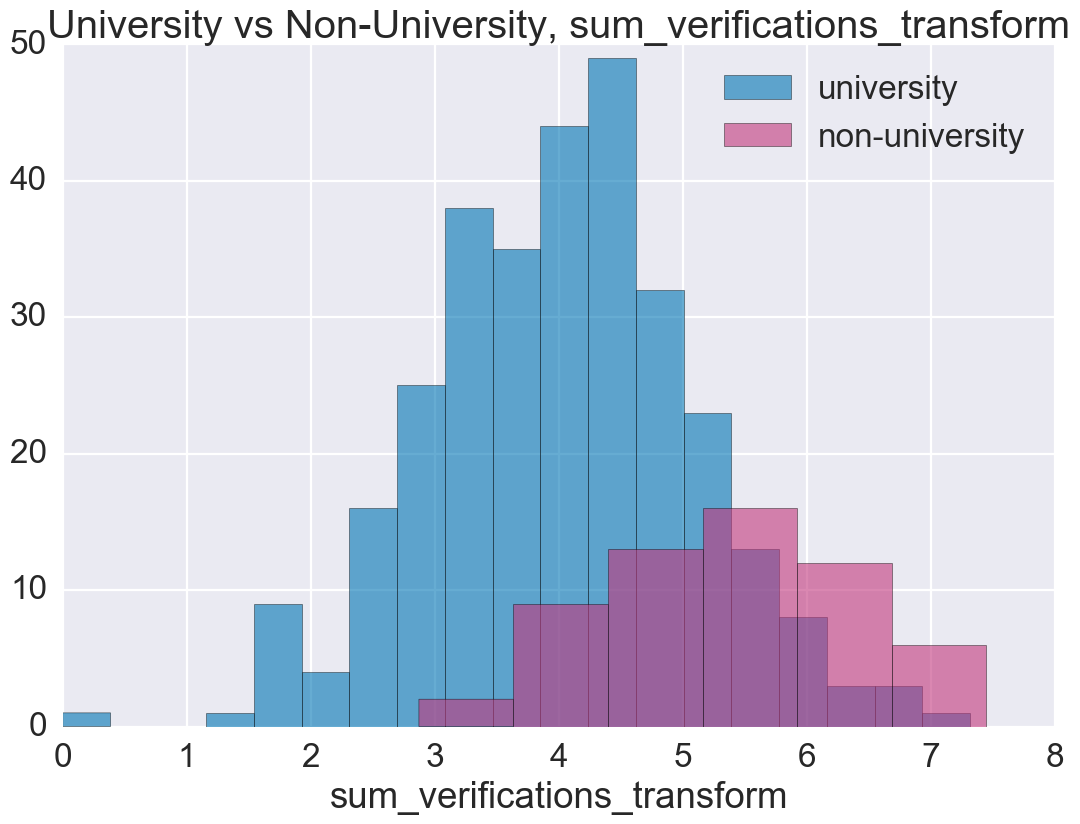

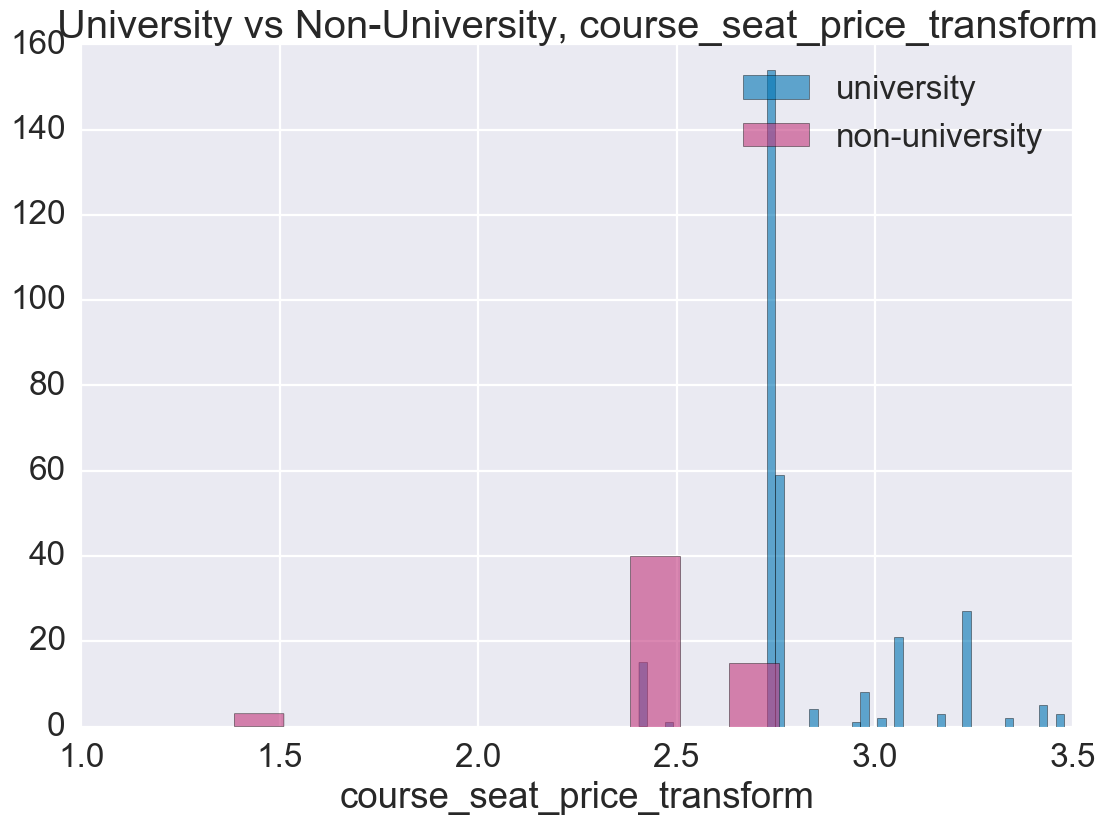

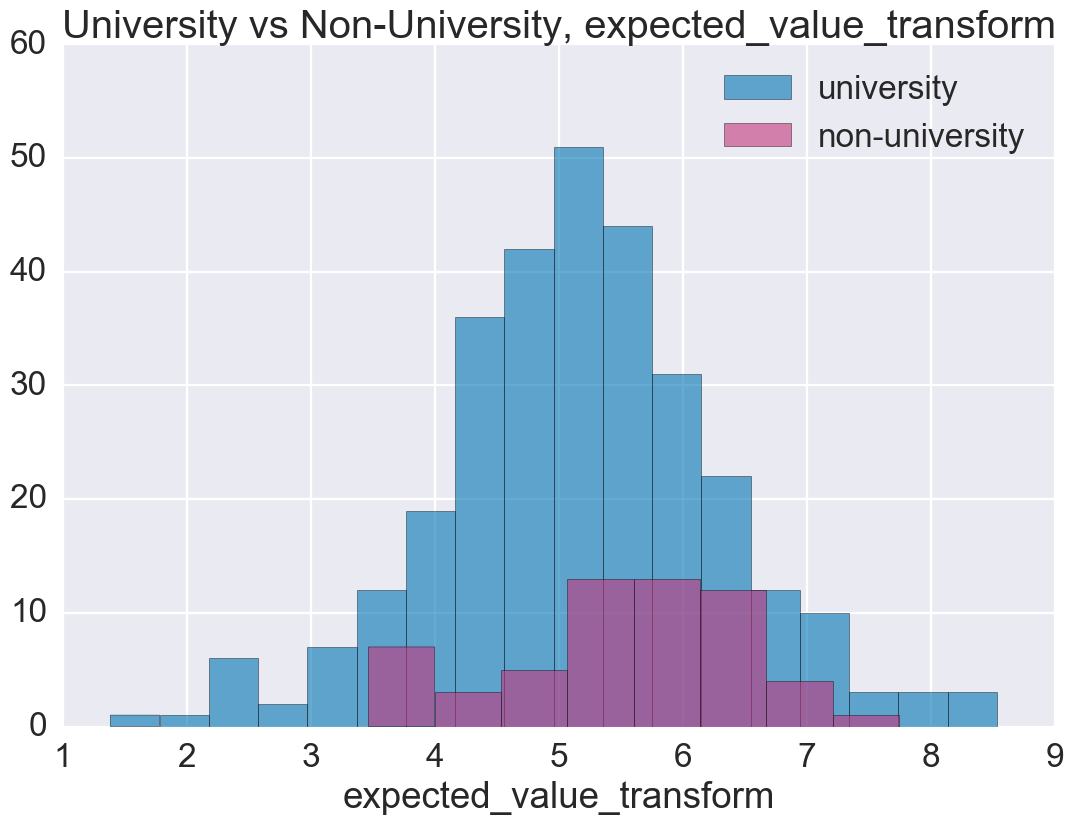

In [225]:
for i in plot_list:
    plot_distributions(df[df['stem_non_stem']!='STEM'],i)